<a href="https://colab.research.google.com/github/nrenzan/AbstractiveTextSummarization/blob/main/Copy_of_DL_og.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uncomment the code below if you are running on google colab
If you are running the code on the google colab then you must have the data set on your google drive. Link to the dataset where you can download it form https://drive.google.com/file/d/1CAK0Cj1kNgoZ0FRxwwCflbh-1-hKDPoK/view?usp=sharing



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [2]:
#!unzip /content/drive/MyDrive/DL/data.zip # Comment out for niranjan's
!unzip /content/drive/MyDrive/MiniProjectdata/amazon.zip #comment out for Angel's



Archive:  /content/drive/MyDrive/MiniProjectdata/amazon.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import textwrap
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# data_train=pd.read_csv('/content/cnn_dailymail/train.csv')
#data_test=pd.read_csv('/content/cnn_dailymail/test.csv')
#data_validation=pd.read_csv('/content/cnn_dailymail/validation.csv')
data_train=pd.read_csv('/content/Reviews.csv',nrows=100000)

Data preprocessing

In [7]:
#data = pd.concat([data_train, data_test, data_validation ])
df = data_train

In [8]:
new_df=df.sample(5000)

In [9]:
new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
43579,43580,B001EQ4P2I,A1ZIWZYLSYA98R,"Terry P ""mrdata98""",1,1,5,1318464000,Spicy sweet kick,"Great BBQ flavor with enough Habanero to give it a nice little kick. The flavors are not overwhelming, so the taste of the almond still shines through. A really nice snack that's just a little d..."
63140,63141,B00451SEJ4,A19LWTHOBSTOIZ,Paresh Sinha,1,1,5,1326153600,Great coffee!!!,Caribou Coffee is a rarity in NY/NJ area. I have been missing it since I left Minneapolis about 6 years back but now I can get it on Amazon. The price is great and the coffee always arrives fresh....
65574,65575,B001EQ55ZO,A2GPEV42IO41CI,Kona,1,1,1,1214956800,How could they do this to cashews?,"I love cashews, but Emerald Sea Salt and Pepper Cashews have too much pepper on them for me. They look dirty, taste peppery, and leave a burning sensation in my mouth. The pepper takes over comp..."


In [10]:
new_df.shape

(5000, 10)

In [11]:
#sample=new_df.sample()
#print("****Text****")
#print(sample.Text.values)
#print('****Summary****')
#print(sample.Summary.values)

Checking for Null values


In [14]:
new_df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

Checking for duplicates


In [15]:
new_df.duplicated(subset=['Text']).sum()

40

In [16]:
new_df=new_df.drop_duplicates(subset=['Text'])
new_df.shape

(4960, 10)

In [17]:
new_df.duplicated(subset=['Text']).sum()

0

In [20]:
new_df['Text'][:10]

43579    great bbq flavor with enough habanero to give it a nice little kick.  the flavors are not overwhelming, so the taste of the almond still shines through.  a really nice snack that's just a little d...
63140    caribou coffee is a rarity in ny/nj area. i have been missing it since i left minneapolis about 6 years back but now i can get it on amazon. the price is great and the coffee always arrives fresh....
65574    i love cashews, but emerald sea salt and pepper cashews have too much pepper on them for me.  they look dirty, taste peppery, and leave a burning sensation in my mouth.  the pepper takes over comp...
22262    3 dogs, 1 loves it and uses it as intended.  the only complaint there is that he's become far too good at it and learned how to push the rope in and out very quickly.  he 48 lbs, gets his regular ...
15488                                                                            all natural,dogs favorite treat. don't give too many because it will constipate dog

In [21]:
new_df['Text'] = new_df['Text'].str.lower()
new_df['Summary'] = new_df['Summary'].str.lower()

new_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
43579,43580,B001EQ4P2I,A1ZIWZYLSYA98R,"Terry P ""mrdata98""",1,1,5,1318464000,spicy sweet kick,"great bbq flavor with enough habanero to give it a nice little kick. the flavors are not overwhelming, so the taste of the almond still shines through. a really nice snack that's just a little d..."
63140,63141,B00451SEJ4,A19LWTHOBSTOIZ,Paresh Sinha,1,1,5,1326153600,great coffee!!!,caribou coffee is a rarity in ny/nj area. i have been missing it since i left minneapolis about 6 years back but now i can get it on amazon. the price is great and the coffee always arrives fresh....
65574,65575,B001EQ55ZO,A2GPEV42IO41CI,Kona,1,1,1,1214956800,how could they do this to cashews?,"i love cashews, but emerald sea salt and pepper cashews have too much pepper on them for me. they look dirty, taste peppery, and leave a burning sensation in my mouth. the pepper takes over comp..."
22262,22263,B000KV61FC,AG8ZNU3005HTT,LBdotSee,2,2,4,1289520000,worth a try!,"3 dogs, 1 loves it and uses it as intended. the only complaint there is that he's become far too good at it and learned how to push the rope in and out very quickly. he 48 lbs, gets his regular ..."
15488,15489,B000255OIG,A3W35OAAB4XNX9,Maryann Aniela Royster,0,0,5,1303862400,dogs love them,"all natural,dogs favorite treat. don't give too many because it will constipate dog. my dogs will do anything for these treats!"


In [22]:
#removing html tags
import re
def remove_html_tags(text):
    if isinstance(text, str):
        pattern = re.compile('<.*?>')
        return pattern.sub(r'', text)
    else:
        return text

Converting to lower case

In [23]:
new_df['Text'] = new_df['Text'].apply(remove_html_tags)

new_df['Summary'] = new_df['Summary'].apply(remove_html_tags)

In [24]:
#removing punchuation


import string
string.punctuation
exclude = string.punctuation
def remove_punc(text):
    if isinstance(text, str):
        return ''.join(ch for ch in text if ch not in exclude)
    else:
        return str(text)  # Convert non-string data to string

In [25]:
new_df['Text'] = new_df['Text'].apply(remove_punc)

new_df['Summary'] = new_df['Summary'].apply(remove_punc)

In [26]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
new_df['Text'] = new_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
new_df['Summary'] = new_df['Summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
new_df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
43579,43580,B001EQ4P2I,A1ZIWZYLSYA98R,"Terry P ""mrdata98""",1,1,5,1318464000,spicy sweet kick,great bbq flavor enough habanero give nice little kick flavors overwhelming taste almond still shines really nice snack thats little different


In [29]:
#!pip install contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [30]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
#call the function
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [32]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [33]:
df['Summary'] = df['Summary'].astype(str)

In [34]:
#call the function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [35]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [36]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [37]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

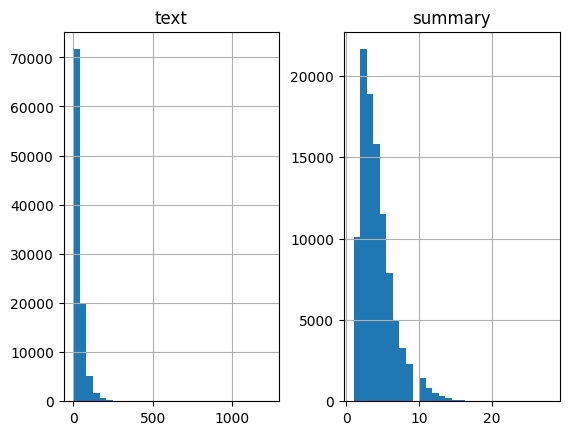

In [38]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [39]:
max_len_text=300
max_len_summary=100

In [40]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.9421608367112045


In [41]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [42]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [43]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [44]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [45]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)
print(tot_cnt-cnt)

% of rare words in vocabulary: 62.30097087378641
Total Coverage of rare words: 1.3306146811319115
19415


In [46]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1


In [47]:
x_voc

19416

In [48]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Reducing the x_voc_size could help us to remove the number of parameters in the embedding layers.
Taking the threshold of the rare words can help us remvoe the number of parameters.
Else we have to change the dataset to something smaller

In [49]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 73.98449171231415
Total Coverage of rare words: 3.423283300636065


End of the tokenization method for x and begining of the tokenization of y
for y only one method is used so far and based on the performance of the x tokenization. One of the method is used.

In [50]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=10000)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [51]:
y_voc

10001

In [52]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(89753, 89753)

In [53]:
type(y_tr)

numpy.ndarray

In [54]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [55]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [56]:
from keras import backend as K
K.clear_session()
latent_dim = 16
embedding_dim=32 #Keeping latent dimension to 300 and introducing embedding dimension of 100 to reduce the number of parameters of the model
#condider chaging the latent_dim to smaller value such as 100 or 300
#also adding a seperate embedding_dim can help to reduce the compleixity of the model

Using word2vec

In [57]:
#Creating a single shared embedding
#shared_emb_layer = Embedding(max(x_voc, y_voc), embedding_dim, trainable=True)


In [58]:
#encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#enc_emb = shared_emb_layer(encoder_inputs)

In [59]:
#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

'''encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)'''

'encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)\nencoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)'

In [60]:
#decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
#dec_emb = shared_emb_layer(decoder_inputs)

In [61]:
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h2, state_c2])


In [62]:
#pip install attention_keras
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs,verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [63]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_output2, decoder_outputs])

In [64]:
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [65]:
#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [66]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 32)              621312    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 300, 16),            3136      ['embedding[0][0]']           
                              (None, 16),                                                     

In [67]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')


In [68]:
#using Early stoppage to stop the training of the model once the validation increasers

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [69]:
batch_size=256

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/drive/MyDrive/savedModels-{epoch:02d}.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq=3 * len(x_tr) // batch_size,  # Use save_freq instead of period
    save_freq_mode='epoch'  # Ensure saving happens at epoch end
)

In [1]:
history=model.fit(
    [x_tr,y_tr[:,:-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
    epochs=10,callbacks=[es,checkpoint_callback],
    batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


NameError: ignored

In [ ]:
'''history=model.fit(
    [x_tr,y_tr[:,:-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]
    ,epochs=20,callbacks=[es],
    batch_size=256,
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))'''

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_output2, state_h2, state_c2])

In [ ]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

In [ ]:
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

In [ ]:
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



In [ ]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [ ]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [ ]:
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

In [ ]:
Hello how are you?